# Credit Score Detection

## Importing Libraries 

In [234]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import SMOTE


## Get Dataset 

In [235]:
data = pd.read_csv("C:/Users/Jeffr/OneDrive/Documents/work/ML/credit_customers.csv")
print(data)

    checking_status  duration                  credit_history  \
0                <0       6.0  critical/other existing credit   
1          0<=X<200      48.0                   existing paid   
2       no checking      12.0  critical/other existing credit   
3                <0      42.0                   existing paid   
4                <0      24.0              delayed previously   
..              ...       ...                             ...   
995     no checking      12.0                   existing paid   
996              <0      30.0                   existing paid   
997     no checking      12.0                   existing paid   
998              <0      45.0                   existing paid   
999        0<=X<200      45.0  critical/other existing credit   

                 purpose  credit_amount    savings_status  employment  \
0               radio/tv         1169.0  no known savings         >=7   
1               radio/tv         5951.0              <100      1<=X<4   


## One-hot-encoding

In [236]:
features_to_encode = ["checking_status", "credit_history", "purpose", "savings_status", "other_payment_plans", 
                      "employment", "personal_status", "other_parties", "property_magnitude","housing", "job"]

one_hot_encoded = pd.get_dummies(data[features_to_encode]) 
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop(features_to_encode, axis=1)

data['own_telephone']  = data['own_telephone'].replace({"none": 0, "yes": 1})
data['foreign_worker']  = data['foreign_worker'].replace({"no": 0, "yes": 1})
data['class']  = data['class'].replace({"bad": 0, "good": 1})
df = pd.DataFrame(data)
print(len(df.columns.tolist()))

60


## Scaling Data using StandardScalar

In [237]:
df = pd.DataFrame(data)

columns_to_scale = ['num_dependents', 'existing_credits', 'age', 'residence_since',
                    'installment_commitment', 'credit_amount', 'duration']


scaler = StandardScaler()
scaled = scaler.fit_transform(df[columns_to_scale])
scaled_columns = pd.DataFrame(scaled, columns=columns_to_scale, index=df.index)
df[columns_to_scale] = scaled_columns
print(df)

     checking_status_0<=X<200  checking_status_<0  checking_status_>=200  \
0                           0                   1                      0   
1                           1                   0                      0   
2                           0                   0                      0   
3                           0                   1                      0   
4                           0                   1                      0   
..                        ...                 ...                    ...   
995                         0                   0                      0   
996                         0                   1                      0   
997                         0                   0                      0   
998                         0                   1                      0   
999                         1                   0                      0   

     checking_status_no checking  credit_history_all paid  \
0                         

## Data Class Percentage

1    700
0    300
Name: class, dtype: int64


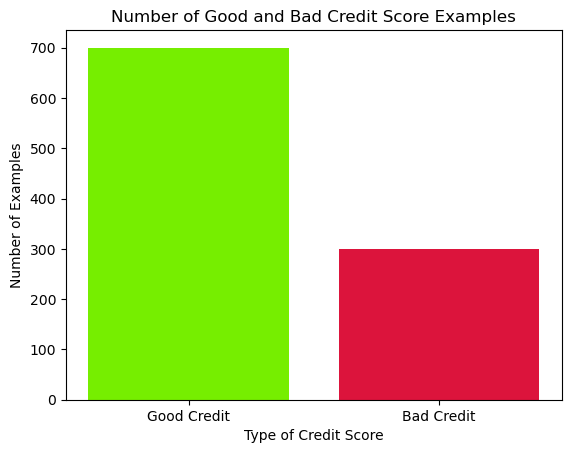

In [238]:
print(df["class"].value_counts())

plt.bar((["Good Credit", "Bad Credit"]), ([700, 300]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score Examples')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## Data Splitting and Bias

(700, 60) (300, 60) (700,) (300,)
491
209


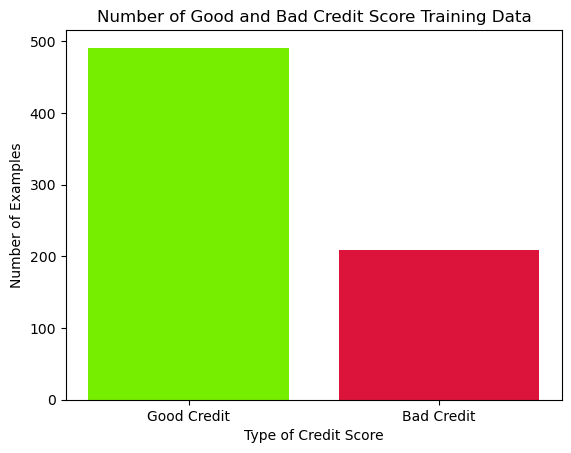

In [239]:
X = df.drop("class", axis = 1)
y = data["class"]

X = np.array(X)
y = np.array(y)

ones_column = np.ones((X.shape[0], 1))
X = np.hstack((ones_column, X))

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print((y_train == 1).sum()) #491
print((y_train == 0).sum()) #209
plt.bar((["Good Credit", "Bad Credit"]), ([491, 209]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score Training Data')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## SMOTES Technique 

491
491


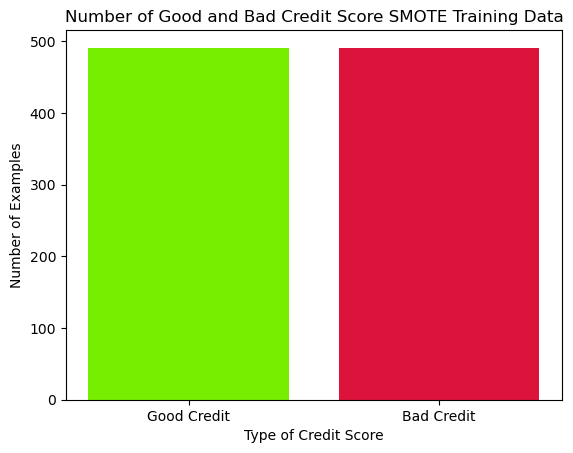

In [240]:
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print((y_train == 1).sum()) #491
print((y_train == 0).sum()) #491

plt.bar((["Good Credit", "Bad Credit"]), ([491, 491]), color=['#76EE00', '#DC143C'])
plt.title('Number of Good and Bad Credit Score SMOTE Training Data')
plt.xlabel('Type of Credit Score')
plt.ylabel('Number of Examples')
plt.show()

## Logistic Regression

### Polynomial Transformation


Degree 1: Training accuracy = 0.776, Test accuracy = 0.750
Degree 2: Training accuracy = 1.000, Test accuracy = 0.733
Degree 3: Training accuracy = 1.000, Test accuracy = 0.730


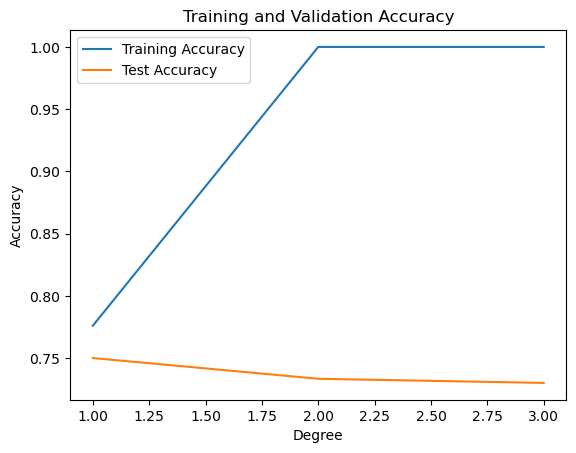

In [241]:
train_accuracy = []
test_accuracy = []

for i in range(3):
    polyTransform = PolynomialFeatures(degree=i+1, include_bias=False)
    X_train_poly = polyTransform.fit_transform(X_train)
    X_test_poly = polyTransform.transform(X_test)  # Transform the test data
    
    logisticRegr = LogisticRegression(max_iter = 100000)
    logisticRegr.fit(X_train_poly, y_train)
    
    y_pred_train = logisticRegr.predict(X_train_poly)
    accuracy_train = accuracy_score(y_train, y_pred_train)  # Calculate accuracy on training set
    train_accuracy.append(accuracy_train)
    
    y_pred_test = logisticRegr.predict(X_test_poly)
    accuracy_test = accuracy_score(y_test, y_pred_test)  # Calculate accuracy on test set
    test_accuracy.append(accuracy_test)
    
    print(f"Degree {i+1}: Training accuracy = {accuracy_train:.3f}, Test accuracy = {accuracy_test:.3f}")

    
plt.plot([1,2,3], train_accuracy, label='Training Accuracy')
plt.plot([1,2,3], test_accuracy, label='Test Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



### Regularization with K-fold validation

Penalty: ('l1', 'liblinear'), Folds: 2, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 3, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 4, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 5, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 6, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 7, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 8, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 9, Best C Value: 1.0
Training accuracy: 0.774
Test accuracy: 0.747

Penalty: ('l1', 'liblinear'), Folds: 10, Best C Value: 100.0
Training accuracy: 0.775
Test accuracy: 0.763



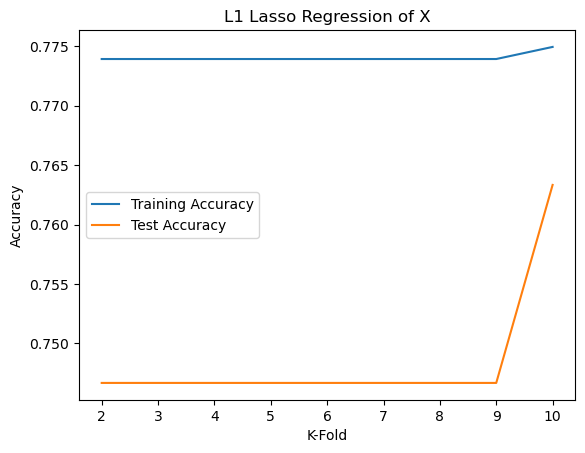

Penalty: ('l2', 'lbfgs'), Folds: 2, Best C Value: 0.1
Training accuracy: 0.767
Test accuracy: 0.727

Penalty: ('l2', 'lbfgs'), Folds: 3, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 4, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 5, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 6, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 7, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 8, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 9, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750

Penalty: ('l2', 'lbfgs'), Folds: 10, Best C Value: 1.0
Training accuracy: 0.776
Test accuracy: 0.750



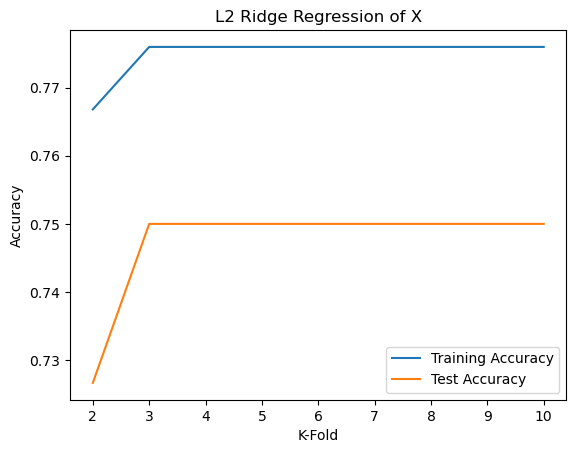

In [242]:
k = 2
penalty_reg =[("l1", "liblinear"), ("l2",'lbfgs')]
C = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

for i in penalty_reg:
    train_accuracy = []
    test_accuracy = []
    best_C = []
    for a in range(9):
        logisticRegrCV = LogisticRegressionCV(cv=k+a, penalty=i[0], random_state=42, max_iter = 100000, solver=i[1],Cs = C)
        logisticRegrCV.fit(X_train, y_train)
        
        y_pred_train = logisticRegrCV.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        train_accuracy.append(accuracy_train)
        
        y_pred_test = logisticRegrCV.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test) 
        test_accuracy.append(accuracy_test)
        
        best_C.append(logisticRegrCV.C_[0])
        
        print(f"Penalty: {i}, Folds: {k+a}, Best C Value: {logisticRegrCV.C_[0]}")
        print(f"Training accuracy: {accuracy_train:.3f}")
        print(f"Test accuracy: {accuracy_test:.3f}")
        print()
        
    plt.plot([2,3,4,5,6,7,8,9,10], train_accuracy, label='Training Accuracy')
    plt.plot([2,3,4,5,6,7,8,9,10], test_accuracy, label='Test Accuracy')
    if i[0] == "l1":
        plt.title("L1 Lasso Regression of X")
    else:
        plt.title("L2 Ridge Regression of X")
    plt.xlabel('K-Fold')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
